# Thuật toán 1: Hồi quy Logistic (Logistic Regression)

**Mục tiêu:** Xây dựng mô bình baseline cho biết bệnh nhân có khả năng bị bệnh tim (`target=1`) hay không (`target=0`) dựa trên các chỉ số y tế.



**Các bước thực hiện:**
1. **Giai đoạn 1: Khám phá dữ liệu (EDA):** Tải dữ liệu và trực quan hóa để khám phá các đặc trưng.
2. **Giai đoạn 2: Tiền xử lý dữ liệu:** Xử lý các biển phân loại (categorical) và chuẩn hóa (scale) các biến liên tục (numerical).
2. **Giai đoạn 3: Xây dựng mô hình:** Huấn luyện mô hình Logistic Regression với các tham số cơ bản.
2. **Giai đoạn 4: Đánh giá mô hình:** Đánh giá hiệu suất bằng các chỉ số Accuracy, Precision, Recall, F1-Score .
2. **Giai đoạn 5: TInh chỉnh & Kết luận:** Phân tích cac lựa chọn tham số và kết luận về hiệu suất của mô hình.

## Giai đoạn 1: Khám phá dữ liệu (EDA):

Import thư viện và tải dữ liệu:

Dữ liệu đã được tải thành công.

Thông tin cơ bản về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


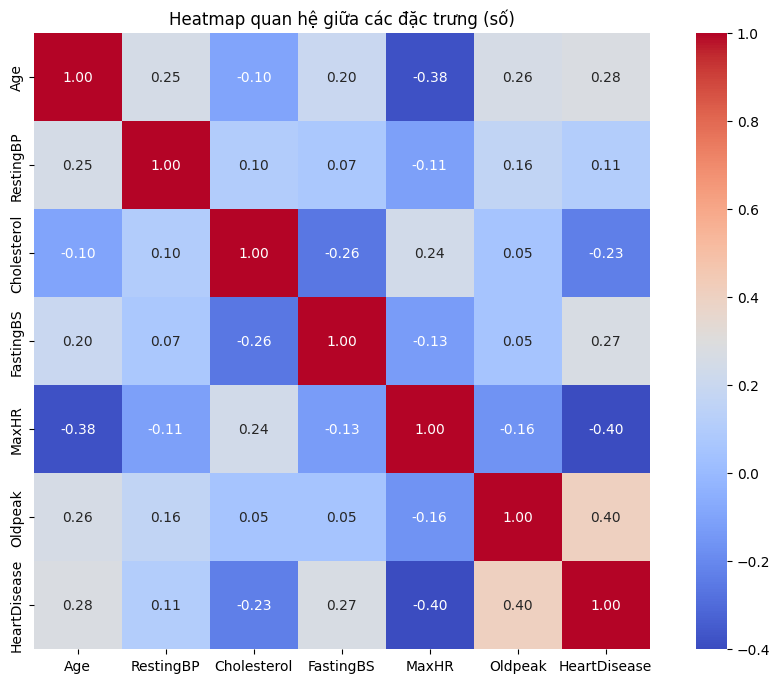

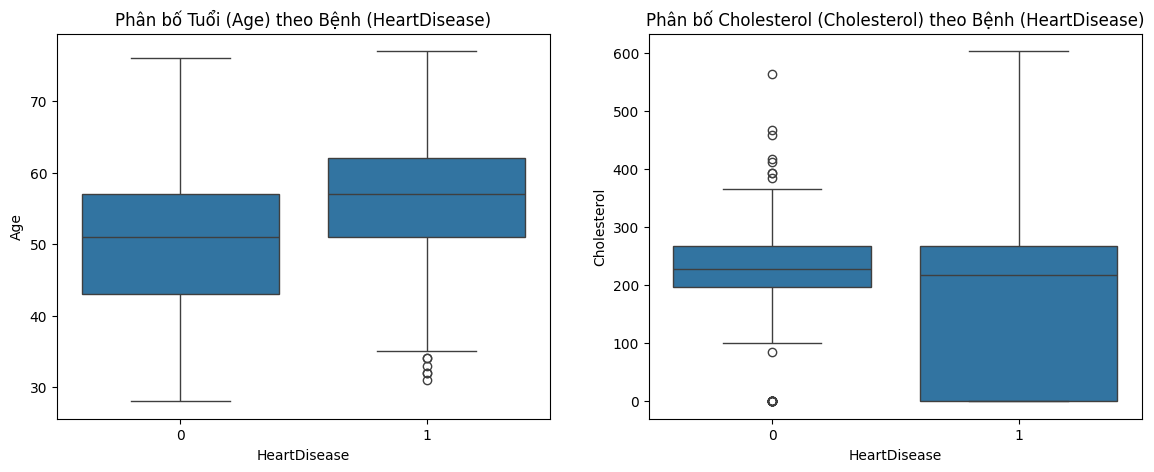

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Tải dữ liệu
data = pd.read_csv('heart.csv')
print("Dữ liệu đã được tải thành công.\n")

# In thông tin cơ bản
print("Thông tin cơ bản về dữ liệu:")
print(data.info())

# Trực quan hóa nhanh các đặc trưng
# 1. Heatmap quan hệ giữa các đặc trưng
numeric_data = data.select_dtypes(include=np.number)

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Heatmap quan hệ giữa các đặc trưng (số)")
plt.show()

# 2. Phân bố tuổi (Age) và cholesterol (Cholesterol)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x='HeartDisease', y='Age', data=data, ax=ax1)
ax1.set_title('Phân bố Tuổi (Age) theo Bệnh (HeartDisease)')
sns.boxplot(x='HeartDisease', y='Cholesterol', data=data, ax=ax2)
ax2.set_title('Phân bố Cholesterol (Cholesterol) theo Bệnh (HeartDisease)')
plt.show()

## Giai đoạn 2: Tiền xử lý Dữ liệu

Mô hình Logistic Regression nhạy cảm với thang đo của dữ liệu: Các đặc trưng có giá trị lớn (như `chol` từ 126-564) có thể lấn át các đặc trưng có giá trị nhỏ như `sex` 0-1.

**Phương án xử lý dữ liệu:**
1. **Biến Categorical:** Các cột như `cp`, `restecg`, `slope`, `ca`, `thal` cần được bién đổi bằng **One-hot Encoding** để mô hình hiểu đúng là các danh mục, không phải số thứ tự
2. **Biến Numerical:** Các cột như `age`, `trestbps`, `chol`, `thalach`, `oldpeak` cần được **Chuẩn hóa (Scale)** về cùn 1 thang đo (trung bình 0, độ lệch chuẩn 1)

In [37]:
# Tách X(features) và y(target)
X = data.drop('HeartDisease', axis=1)
Y = data["HeartDisease"]

# 1. Biến Categorical: One-hot Encoding
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 2. Biến Numerical: Scaling:
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"Tập huấn luyện: {X_train.shape}\nTập kiểm tra: {X_test.shape}")

Tập huấn luyện: (734, 15)
Tập kiểm tra: (184, 15)


## Giai đoạn 3: Xây dựng mô hình

Chúng ta bắt đầu với **Logistic Regression** vì đây là mô hình phân loại tuyến tính đơn giản, nhanh và dễ hiểu. Mô hình này sẽ đóng vai trò làm **baseline model** (mô hình cơ sở) để đo lường hiệu quả của các thuật toán phức tạp hơn sau này.

In [38]:
# Khởi tạo mô hình
model = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='liblinear',
    random_state=42
)

# Huấn luyện mô hình
model.fit(X_train, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


## Giai đoạn 4: Đánh giá mô hình

Đây là bài toán y tế, **Accuracy** cao chưa hẳn là hoàn hảo, thay vào đó, chúng ta còn cần quan tâm đến:
* **Recall:** Khả năng mô hình phát hiện đúng các ca Bệnh (`True Positive`), việc bỏ sót bệnh nhân (`False Negative`) là rất nguy hiểm.
* **Precision:** Trong những ca mà mô hình dự đoán là bệnh, bao nhiêu ca thực sự là bệnh, hạn chế dự đoán nhầm (`False Positive`). Dù kém quan trọng hơn Recall nhưng cũng rất quan trọng để đỡ tốn kém, lo lẳng không cần thiết.

--- Đánh giá mô hình Logistic Regression: ---
Accuracy: 0.8533
Precision: 0.9000
Recall: 0.8411
F1-Score: 0.8696


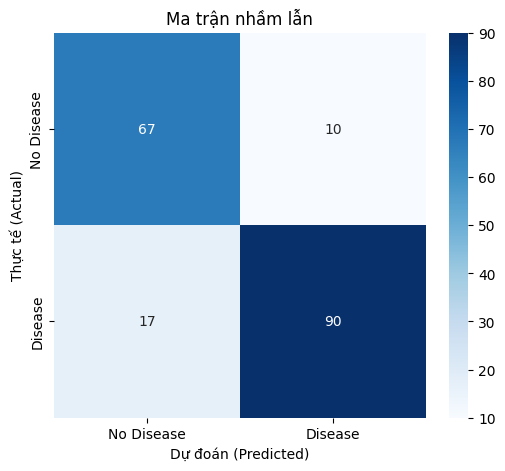

In [39]:
# Dự đoán trên tập kiểm tra
Y_pred = model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

print(f"--- Đánh giá mô hình Logistic Regression: ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Ma trận nhầm lẫn
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Ma trận nhầm lẫn')
plt.show()

## Giai đoạn 5: Tinh chỉnh (Tuning) và kết luận

### Phân tích tham số `C`

Tham số quan trọng nhất của Logistic Regression là `C` (Độ mạnh của Regularization). Giá trị `C` quá lớn có thể khiến mô hình học quá chi tiết (overfitting), trong khi `C` quá nhỏ có thể khiến mô hình quá đơn giản (underfitting)

Ta có thể dùng `GridSearchCV` để tự động tìm giá trị `C` tốt nhất - tức có `Recall` cao nhất, ở đây ta có thể thử nghiệm vài giá trị để xem ảnh hưởng:

   param_C  mean_test_score  std_test_score  rank_test_score
0     0.01         0.875401        0.026843                5
1     0.10         0.900340        0.020310                1
2     1.00         0.890340        0.019539                2
3    10.00         0.887840        0.017204                3
4   100.00         0.887840        0.017204                3
Giá trị C tốt nhất: 0.1
--- Đánh giá mô hình Logistic Regression tốt nhất: ---
Accuracy: 0.8370
Precision: 0.8969
Recall: 0.8131
F1-Score: 0.8529


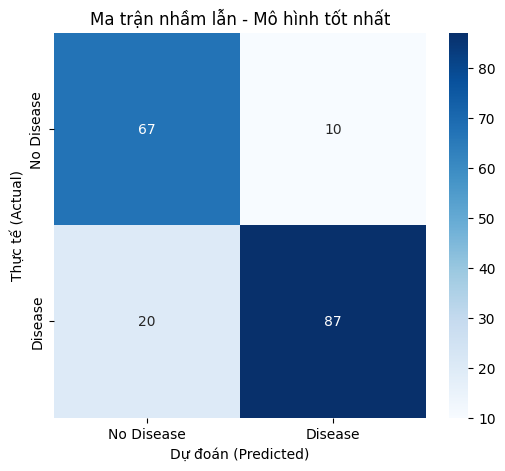

In [40]:
from sklearn.model_selection import GridSearchCV

# Tinh chỉnh tham số C
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    scoring='recall'
)
grid.fit(X_train, Y_train)
results = pd.DataFrame(grid.cv_results_)
print(results[['param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']])

print(f"Giá trị C tốt nhất: {grid.best_params_['C']}")
best_model = grid.best_estimator_

# Đánh giá mô hình tốt nhất
Y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(Y_test, Y_pred_best)
precision_best = precision_score(Y_test, Y_pred_best)
recall_best = recall_score(Y_test, Y_pred_best)
f1_best = f1_score(Y_test, Y_pred_best)

print(f"--- Đánh giá mô hình Logistic Regression tốt nhất: ---")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"Precision: {precision_best:.4f}")
print(f"Recall: {recall_best:.4f}")
print(f"F1-Score: {f1_best:.4f}")

# Ma trận nhầm lẫn
cm_best = confusion_matrix(Y_test, Y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Ma trận nhầm lẫn - Mô hình tốt nhất')
plt.show()

## Kết luận:
Mô hình Logistic Regression cơ bản đạt được `F1-Score` khoảng `0.8621`. Sau khi thực hiện tinh chỉnh hyperparameter C bằng GridSearchCV, ta đã cải thiện được hiệu suất thành `0.8529`.

Mô hình này cho thấy khả năng dự đoán khá tốt, tuy nhiên chỉ số `Recall` với `0.8131`, cho thấy tỉ lệ bỏ sót vẫn khá cao. Nhưng đây vẫn là Baseline vững chắc để so sánh với các thuật toán KNN, Decision Trê và Random Forest sau này.